In [89]:
import numpy as np
import csv
import pandas as pd
import utils as ut
import matplotlib.pyplot as plt
import copy

# Data preparation

In [4]:
test = np.genfromtxt('MNIST/mnist_test.csv', delimiter=',')
train = np.genfromtxt('MNIST/mnist_train.csv', delimiter=',')
print(f"test shape : {test.shape} \ntrain shape : {train.shape}")

# normalisation

test_data, test_labels = test[:,1:]/255, test[:,0]
train_data, train_labels = train[:,1:]/255, train[:,0]
print(f"test data shape :{test_data.shape}")
print(f"test labels shape :{test_labels.shape}")
print(f"train data shape :{train_data.shape}")
print(f"train labels shape :{train_labels.shape}")

# classes proportions

train_prop, test_prop = np.zeros(10), np.zeros(10)
for i in range(10):
    test_prop[i] = len(np.where(test_labels == i)[0])
    train_prop[i] = len(np.where(train_labels == i)[0])
print("\ntrain classes proportions :")
print(train_prop/train_prop.sum(0))
print("-"*25)
print("test classes proportions :")
print(test_prop/test_prop.sum(0))

# 0 vs others

zeros_test = np.where(test_labels == 0)[0]
non_zeros_test = np.where(test_labels != 0)[0]
zeros_train = np.where(train_labels == 0)[0]
non_zeros_train = np.where(train_labels != 0)[0]
test_labels[zeros_test], test_labels[non_zeros_test] = 1, -1
train_labels[zeros_train], train_labels[non_zeros_train] = 1, -1

test shape : (10000, 785) 
train shape : (60000, 785)
test data shape :(10000, 784)
test labels shape :(10000,)
train data shape :(60000, 784)
train labels shape :(60000,)

train classes proportions :
[0.09871667 0.11236667 0.0993     0.10218333 0.09736667 0.09035
 0.09863333 0.10441667 0.09751667 0.09915   ]
-------------------------
test classes proportions :
[0.098  0.1135 0.1032 0.101  0.0982 0.0892 0.0958 0.1028 0.0974 0.1009]


label : -1.0


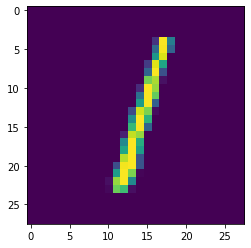

In [130]:
idx = 2
plt.imshow(test_data[idx].reshape(28,28))
print(f"label : {test_labels[idx]}")

# Batch Gradient Descent

In [59]:
def hinge_loss(X,A,B):
    """
    Support vectorize and scalar computation
    """
    batch_size = len(B)

    product = np.dot(A,X)
    loss = np.maximum(np.zeros(batch_size), 1 - product*B)
    correct = np.where(loss == 0)[0]
    return loss, correct


def reg_hinge_loss(X,A,B,alpha=0,test=False):
    loss, correct = hinge_loss(X,A,B)
    if test:
        grad = []
    else:
        grad = -A*B.reshape(len(B),1)
        grad[correct] = 0
    accuracy = len(correct)/len(B)
    return np.mean(loss) + (alpha/2)*sum(X**2), np.mean(grad,0) + alpha*X, accuracy


def simplex_proj(x):
    x_s = np.sort(x, kind='quicksort')[::-1]
    cum_s = np.cumsum(x_s)
    r = x_s - (cum_s-1)/(np.arange(len(x))+1)
    d0 = np.max(np.where(r>0)[0]) + 1
    theta = (cum_s[d0-1] -1)/d0

    return np.maximum(0,x-theta)

def l1_ball_proj(x,z=1):
    if sum(abs(x)) <= z:
        return x
    else:
        w = simplex_proj(abs(x)/z)
        return z*np.sign(x)*w

def weighted_simplex_proj(x,D):
    """
    x : vector, D : diag matrix
    """
    dx = np.abs(np.dot(D,x))
    sorted_indices = np.argsort(-dx, kind='quicksort')
    sx = np.cumsum(x[sorted_indices])
    sd = np.cumsum(1/np.diag(D)[sorted_indices])
    res = (sx-1)/

In [95]:
a = np.array([1,2,3])
b = np.identity(3)

In [101]:
i = np.argsort(-np.abs(np.dot(a,b)), kind='quicksort')

In [107]:
1/(2*np.diag(b)[i])

array([0.5, 0.5, 0.5])

In [6]:
np.random.seed(1)
dim = test_data.shape[1] + 1
alpha = 1/3
epoch = 100

accuracy_train, accuracy_test, loss_train, loss_test = [], [], [], []

train_A = np.column_stack((train_data,np.ones(train_data.shape[0])))
test_A = np.column_stack((test_data,np.ones(test_data.shape[0])))

train_B = train_labels
test_B = test_labels

X = np.random.rand(dim)

# init
l_train, _, acc_train = reg_hinge_loss(X,train_A,train_B,alpha)
l_test, _, acc_test = reg_hinge_loss(X,test_A,test_B,alpha, test=True)
accuracy_train.append(acc_train), accuracy_test.append(acc_test)
loss_train.append(l_train), loss_test.append(l_test)
print(f"init : train loss {'%.2f'%l_train}, train acc {'%.2f'%acc_train}, test loss {'%.2f'%l_test}, test acc {'%.2f'%acc_test}")
print("-"*25)

# training loop
for t in range(1,epoch):
    step = 1/(alpha*t)
    l_train, grad, acc_train = reg_hinge_loss(X,train_A,train_B,alpha)
    l_test, _, acc_test = reg_hinge_loss(X,test_A,test_B,alpha, test=True)
    
    X-= step*grad
    #X = l1_ball_proj(X,z=10) # L1 projection

    if t % 10 == 0:
        print(f"epoch {t} : train loss {'%.2f'%l_train}, train acc {'%.2f'%acc_train}, test loss {'%.2f'%l_test}, test acc {'%.2f'%acc_test}")

    accuracy_train.append(acc_train), accuracy_test.append(acc_test)
    loss_train.append(l_train), loss_test.append(l_test)

print("-"*25)
print(f"final : train loss {'%.2f'%l_train}, train acc {'%.2f'%acc_train}, test loss {'%.2f'%l_test}, test acc {'%.2f'%acc_test}")

init : train loss 90.33, train acc 0.10, test loss 91.17, test acc 0.10
-------------------------
epoch 10 : train loss 0.27, train acc 0.92, test loss 0.26, test acc 0.93
epoch 20 : train loss 0.14, train acc 0.84, test loss 0.14, test acc 0.85
epoch 30 : train loss 0.14, train acc 0.82, test loss 0.13, test acc 0.82
epoch 40 : train loss 0.14, train acc 0.81, test loss 0.13, test acc 0.82
epoch 50 : train loss 0.14, train acc 0.81, test loss 0.13, test acc 0.82
epoch 60 : train loss 0.14, train acc 0.81, test loss 0.13, test acc 0.82
epoch 70 : train loss 0.14, train acc 0.81, test loss 0.13, test acc 0.82
epoch 80 : train loss 0.14, train acc 0.81, test loss 0.13, test acc 0.82
epoch 90 : train loss 0.14, train acc 0.81, test loss 0.13, test acc 0.82
-------------------------
final : train loss 0.14, train acc 0.81, test loss 0.13, test acc 0.82


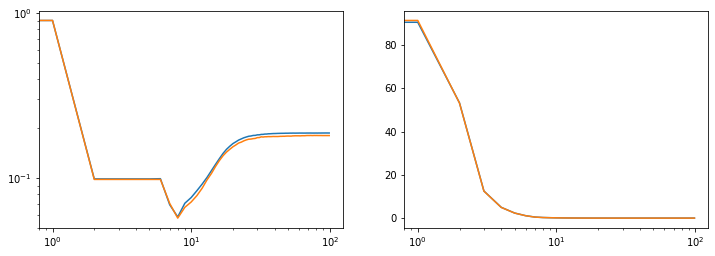

In [20]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(1 - np.array(accuracy_train), label="acc. train")
ax[0].plot(1 - np.array(accuracy_test), label="acc. test")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].plot(loss_train, label="loss train")
ax[1].plot(loss_test, label="loss test")
ax[1].set_xscale('log')
plt.show()

In [184]:
sum(abs(X))

9.691490056383618

# Stochastic Gradient Descent

In [76]:
dim = test_data.shape[1] + 1
alpha = 1/3
epoch = 1000

accuracy_train, accuracy_test, loss_train, loss_test = [], [], [], []

train_A = np.column_stack((train_data,np.ones(train_data.shape[0])))
test_A = np.column_stack((test_data,np.ones(test_data.shape[0])))

train_B = train_labels
test_B = test_labels

train_samples = np.random.choice(len(train_B), epoch) # get the samples for stochastic GD

X = np.random.rand(dim)

# init
l_train, _, acc_train = reg_hinge_loss(X,train_A,train_B,alpha)
l_test, _, acc_test = reg_hinge_loss(X,test_A,test_B,alpha, test=True)
accuracy_train.append(acc_train), accuracy_test.append(acc_test)
loss_train.append(l_train), loss_test.append(l_test)
print(f"init : train loss {'%.2f'%l_train}, train acc {'%.2f'%acc_train}, test loss {'%.2f'%l_test}, test acc {'%.2f'%acc_test}")
print("-"*25)

# training loop
i=1
for t in train_samples:
    step = 1/(alpha*epoch)
    sample_A = np.expand_dims(train_A[t],axis=0)
    sample_B = np.expand_dims(train_B[t],axis=0)
    l_train, grad, acc_train = reg_hinge_loss(X,sample_A,sample_B,alpha)
    l_test, _, acc_test = reg_hinge_loss(X,test_A,test_B,alpha, test=True)
    
    X-= step*grad
    X = l1_ball_proj(X,z=100) # L1 projection

    if i%100==0:
        print(f"epoch {i} : train loss {'%.2f'%l_train}, train acc {'%.2f'%acc_train}, test loss {'%.2f'%l_test}, test acc {'%.2f'%acc_test}")

    accuracy_train.append(acc_train), accuracy_test.append(acc_test)
    loss_train.append(l_train), loss_test.append(l_test)
    i+=1

print("-"*25)
print(f"final : train loss {'%.2f'%l_train}, train acc {'%.2f'%acc_train}, test loss {'%.2f'%l_test}, test acc {'%.2f'%acc_test}")

init : train loss 95.96, train acc 0.10, test loss 96.86, test acc 0.10
-------------------------
epoch 100 : train loss 11.10, train acc 0.00, test loss 7.70, test acc 0.10
epoch 200 : train loss 3.16, train acc 1.00, test loss 3.49, test acc 0.77
epoch 300 : train loss 2.58, train acc 1.00, test loss 2.85, test acc 0.81
epoch 400 : train loss 2.11, train acc 1.00, test loss 2.34, test acc 0.85
epoch 500 : train loss 1.72, train acc 1.00, test loss 1.91, test acc 0.80
epoch 600 : train loss 1.41, train acc 1.00, test loss 1.59, test acc 0.80
epoch 700 : train loss 1.16, train acc 1.00, test loss 1.32, test acc 0.80
epoch 800 : train loss 0.96, train acc 1.00, test loss 1.10, test acc 0.80
epoch 900 : train loss 0.79, train acc 1.00, test loss 0.92, test acc 0.85
epoch 1000 : train loss 0.65, train acc 1.00, test loss 0.78, test acc 0.83
-------------------------
final : train loss 0.65, train acc 1.00, test loss 0.78, test acc 0.83


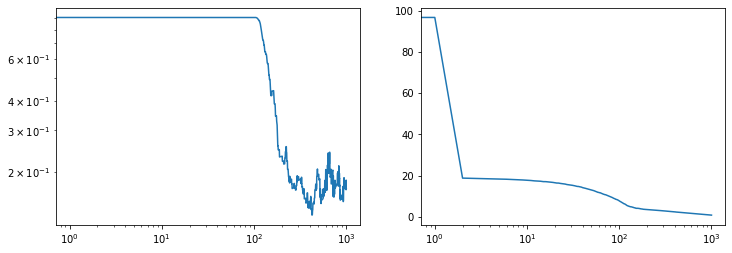

In [77]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
#ax[0].plot(1 - np.array(accuracy_train), label="acc. train")
ax[0].plot(1 - np.array(accuracy_test), label="acc. test")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].plot(loss_train, label="loss train")
ax[1].plot(loss_test, label="loss test")
ax[1].set_xscale('log')
plt.show()

# Online Mirror GD (OMD)

In [69]:
dim = test_data.shape[1] + 1
alpha = 0 # No regularization of hinge loss needed
epoch = 1000

accuracy_train, accuracy_test, loss_train, loss_test = [], [], [], []

train_A = np.column_stack((train_data,np.ones(train_data.shape[0])))
test_A = np.column_stack((test_data,np.ones(test_data.shape[0])))

train_B = train_labels
test_B = test_labels

train_samples = np.random.choice(len(train_B), epoch) # get the samples for stochastic GD

X = np.random.rand(dim)
Y = copy.deepcopy(X) # init dual variablen for OMD

# init
l_train, _, acc_train = reg_hinge_loss(X,train_A,train_B,alpha)
l_test, _, acc_test = reg_hinge_loss(X,test_A,test_B,alpha, test=True)
accuracy_train.append(acc_train), accuracy_test.append(acc_test)
loss_train.append(l_train), loss_test.append(l_test)
print(f"init : train loss {'%.2f'%l_train}, train acc {'%.2f'%acc_train}, test loss {'%.2f'%l_test}, test acc {'%.2f'%acc_test}")
print("-"*25)

# training loop
i=1
for t in train_samples:
    step = (1/i)**(1/2)
    sample_A = np.expand_dims(train_A[t],axis=0)
    sample_B = np.expand_dims(train_B[t],axis=0)
    l_train, grad, acc_train = reg_hinge_loss(X,sample_A,sample_B,alpha)
    l_test, _, acc_test = reg_hinge_loss(X,test_A,test_B,alpha, test=True)
    
    Y-= step*grad
    X = l1_ball_proj(Y,z=100) # L1 projection

    if i%100==0:
        print(f"epoch {i} : train loss {'%.2f'%l_train}, train acc {'%.2f'%acc_train}, test loss {'%.2f'%l_test}, test acc {'%.2f'%acc_test}")

    accuracy_train.append(acc_train), accuracy_test.append(acc_test)
    loss_train.append(l_train), loss_test.append(l_test)
    i+=1

print("-"*25)
print(f"final : train loss {'%.2f'%l_train}, train acc {'%.2f'%acc_train}, test loss {'%.2f'%l_test}, test acc {'%.2f'%acc_test}")

init : train loss 48.12, train acc 0.10, test loss 49.04, test acc 0.10
-------------------------
epoch 100 : train loss 0.00, train acc 1.00, test loss 0.21, test acc 0.92
epoch 200 : train loss 0.00, train acc 1.00, test loss 0.19, test acc 0.92
epoch 300 : train loss 3.11, train acc 0.00, test loss 0.14, test acc 0.95
epoch 400 : train loss 0.38, train acc 0.00, test loss 0.14, test acc 0.96
epoch 500 : train loss 0.00, train acc 1.00, test loss 0.11, test acc 0.96
epoch 600 : train loss 0.00, train acc 1.00, test loss 0.10, test acc 0.95
epoch 700 : train loss 0.00, train acc 1.00, test loss 0.08, test acc 0.96
epoch 800 : train loss 0.00, train acc 1.00, test loss 0.08, test acc 0.96
epoch 900 : train loss 0.00, train acc 1.00, test loss 0.07, test acc 0.97
epoch 1000 : train loss 0.00, train acc 1.00, test loss 0.07, test acc 0.97
-------------------------
final : train loss 0.00, train acc 1.00, test loss 0.07, test acc 0.97


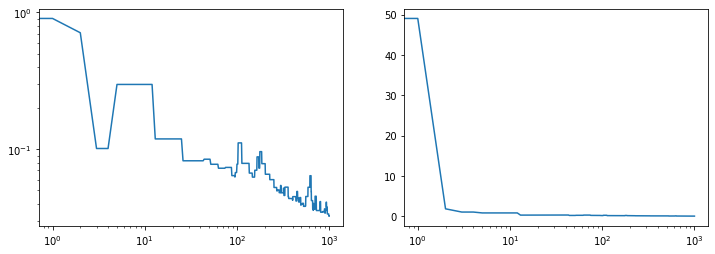

In [70]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
#ax[0].plot(1 - np.array(accuracy_train), label="acc. train")
ax[0].plot(1 - np.array(accuracy_test), label="acc. test")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].plot(loss_train, label="loss train")
ax[1].plot(loss_test, label="loss test")
ax[1].set_xscale('log')
plt.show()

# Stochastic Exponentiated GD (SEG +/-)

In [82]:
d=2
t = np.ones(2*d)/(2*d)

In [84]:
t[2:]

array([0.25, 0.25])

In [87]:
dim = test_data.shape[1] + 1
alpha = 0 # No regularization of hinge loss needed
epoch = 1000
radius = 100 # radius of L1 ball projection

accuracy_train, accuracy_test, loss_train, loss_test = [], [], [], []

train_A = np.column_stack((train_data,np.ones(train_data.shape[0])))
test_A = np.column_stack((test_data,np.ones(test_data.shape[0])))

train_B = train_labels
test_B = test_labels

train_samples = np.random.choice(len(train_B), epoch) # get the samples for stochastic GD

# Init parameters
X = np.random.rand(dim)
W = np.ones(2*dim)/(2*dim)
Teta = np.zeros(2*dim)

# init loss
l_train, _, acc_train = reg_hinge_loss(X,train_A,train_B,alpha)
l_test, _, acc_test = reg_hinge_loss(X,test_A,test_B,alpha, test=True)
accuracy_train.append(acc_train), accuracy_test.append(acc_test)
loss_train.append(l_train), loss_test.append(l_test)
print(f"init : train loss {'%.2f'%l_train}, train acc {'%.2f'%acc_train}, test loss {'%.2f'%l_test}, test acc {'%.2f'%acc_test}")
print("-"*25)

# training loop
i=1
for t in train_samples:
    step = (1/i)**(1/2)
    sample_A = np.expand_dims(train_A[t],axis=0)
    sample_B = np.expand_dims(train_B[t],axis=0)

    # compute loss/ accuracy and gradient
    l_train, grad, acc_train = reg_hinge_loss(X,sample_A,sample_B,alpha)
    l_test, _, acc_test = reg_hinge_loss(X,test_A,test_B,alpha, test=True)

    # Update parameters
    Teta[:dim] -= step*grad
    Teta[dim:] +=step*grad
    W = np.exp(Teta)/sum(np.exp(Teta))
    X = radius*(W[:dim]-W[dim:])

    if i%100==0:
        print(f"epoch {i} : train loss {'%.2f'%l_train}, train acc {'%.2f'%acc_train}, test loss {'%.2f'%l_test}, test acc {'%.2f'%acc_test}")

    accuracy_train.append(acc_train), accuracy_test.append(acc_test)
    loss_train.append(l_train), loss_test.append(l_test)
    i+=1

print("-"*25)
print(f"final : train loss {'%.2f'%l_train}, train acc {'%.2f'%acc_train}, test loss {'%.2f'%l_test}, test acc {'%.2f'%acc_test}")

init : train loss 46.80, train acc 0.10, test loss 47.60, test acc 0.10
-------------------------
epoch 100 : train loss 2.36, train acc 0.00, test loss 0.13, test acc 0.92
epoch 200 : train loss 0.00, train acc 1.00, test loss 0.10, test acc 0.90
epoch 300 : train loss 0.00, train acc 1.00, test loss 0.08, test acc 0.91
epoch 400 : train loss 0.00, train acc 1.00, test loss 0.07, test acc 0.94
epoch 500 : train loss 0.00, train acc 1.00, test loss 0.07, test acc 0.94
epoch 600 : train loss 0.00, train acc 1.00, test loss 0.07, test acc 0.94
epoch 700 : train loss 0.00, train acc 1.00, test loss 0.07, test acc 0.94
epoch 800 : train loss 0.14, train acc 0.00, test loss 0.08, test acc 0.94
epoch 900 : train loss 0.00, train acc 1.00, test loss 0.07, test acc 0.94
epoch 1000 : train loss 0.00, train acc 1.00, test loss 0.06, test acc 0.94
-------------------------
final : train loss 0.00, train acc 1.00, test loss 0.06, test acc 0.94


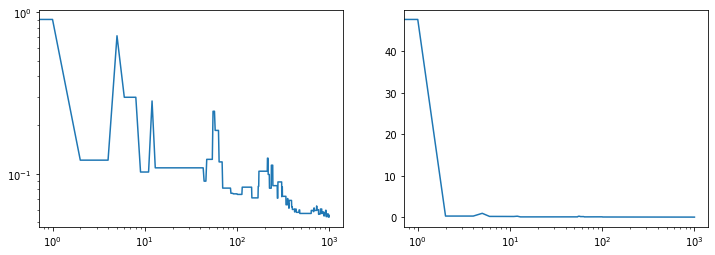

In [88]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
#ax[0].plot(1 - np.array(accuracy_train), label="acc. train")
ax[0].plot(1 - np.array(accuracy_test), label="acc. test")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].plot(loss_train, label="loss train")
ax[1].plot(loss_test, label="loss test")
ax[1].set_xscale('log')
plt.show()

# Adagrad

In [ ]:
dim = test_data.shape[1] + 1
alpha = 0 # No regularization of hinge loss needed
epoch = 1000

accuracy_train, accuracy_test, loss_train, loss_test = [], [], [], []

train_A = np.column_stack((train_data,np.ones(train_data.shape[0])))
test_A = np.column_stack((test_data,np.ones(test_data.shape[0])))

train_B = train_labels
test_B = test_labels

train_samples = np.random.choice(len(train_B), epoch) # get the samples for stochastic GD

# Init parameters
X = np.random.rand(dim)
Y = copy.deepcopy(X)
S = np.zeros(dim)

# init loss
l_train, _, acc_train = reg_hinge_loss(X,train_A,train_B,alpha)
l_test, _, acc_test = reg_hinge_loss(X,test_A,test_B,alpha, test=True)
accuracy_train.append(acc_train), accuracy_test.append(acc_test)
loss_train.append(l_train), loss_test.append(l_test)
print(f"init : train loss {'%.2f'%l_train}, train acc {'%.2f'%acc_train}, test loss {'%.2f'%l_test}, test acc {'%.2f'%acc_test}")
print("-"*25)

# training loop
i=1
for t in train_samples:
    step = (1/i)**(1/2)
    sample_A = np.expand_dims(train_A[t],axis=0)
    sample_B = np.expand_dims(train_B[t],axis=0)

    # compute loss/ accuracy and gradient
    l_train, grad, acc_train = reg_hinge_loss(X,sample_A,sample_B,alpha)
    l_test, _, acc_test = reg_hinge_loss(X,test_A,test_B,alpha, test=True)

    # Update parameters
    S += grad**2
    D = np.diag(S)
    Y = X - step*np.dot(np.linalg.inv(D),grad)
    
    # weighted proj : (TO DO)


    if i%100==0:
        print(f"epoch {i} : train loss {'%.2f'%l_train}, train acc {'%.2f'%acc_train}, test loss {'%.2f'%l_test}, test acc {'%.2f'%acc_test}")

    accuracy_train.append(acc_train), accuracy_test.append(acc_test)
    loss_train.append(l_train), loss_test.append(l_test)
    i+=1

print("-"*25)
print(f"final : train loss {'%.2f'%l_train}, train acc {'%.2f'%acc_train}, test loss {'%.2f'%l_test}, test acc {'%.2f'%acc_test}")

In [91]:
t = np.array([1,2,3])
np.diag(t)

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

In [93]:
t**2

array([1, 4, 9])

In [94]:
np.linalg.inv(np.diag(t))

array([[1.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.33333333]])